In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os
import re
from collections import Counter
from src.utils.preprocess import *
from src.utils.util import *

In [2]:
!nvidia-smi

Sat Nov 12 10:34:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:19:00.0 Off |                  N/A |
| 54%   78C    P0    83W / 250W |      2MiB / 12196MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:1A:00.0 Off |                  N/A |
| 28%   

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 다운로드가 안됨....

caltech_birds2011 데이터는 다운불가

In [5]:
# train_dataset = tfds.load(name='caltech_birds2011', 
#                           split=tfds.Split.TRAIN, 
#                           shuffle_files=True,  # 셔플 유무
#                           as_supervised=True)  # 리턴값 유무 (True 지정시 튜플로 리턴)
# test_dataset = tfds.load(name='caltech_birds2011', 
#                          split=tfds.Split.TEST, 
#                          shuffle_files=True,  # 셔플 유무
#                          as_supervised=True)  # 리턴값 유무 (True 지정시 튜플로 리턴)

In [6]:
# train_data,test_data,info = tfds.load('caltech_birds2011',
#                                   split=(tfds.Split.TRAIN,tfds.Split.TEST),
#                                   with_info=True)

다른 데이터는 다운 가능

In [7]:
# train_data = tfds.load('stanford_dogs',
#                         split=tfds.Split.TRAIN,
#                         with_info=True)

## 직접 데이터로드

## 1. 데이터전처리

경로생성 
- 데이터가 안불러와져서 전처리한 데이터 보관할 processed 폴더 생성
- 동일한 이름으로 생성

In [4]:
raw_path = "dataset/raw/"
processed_path = 'dataset/processed/'
train_path = "dataset/train/"
folder_lst = os.listdir(raw_path)
for i in folder_lst:
    if not os.path.isdir(processed_path+i):
        os.makedirs(processed_path+i)

In [5]:
# 폴더명 리스트
data_lst = sorted(folder_lst) 
data_lst = [i for i in data_lst if i!='.ipynb_checkpoints'] 

In [6]:
data_lst

['001.Black_footed_Albatross',
 '002.Laysan_Albatross',
 '003.Sooty_Albatross',
 '004.Groove_billed_Ani',
 '005.Crested_Auklet',
 '006.Least_Auklet',
 '007.Parakeet_Auklet',
 '008.Rhinoceros_Auklet',
 '009.Brewer_Blackbird',
 '010.Red_winged_Blackbird',
 '011.Rusty_Blackbird',
 '012.Yellow_headed_Blackbird',
 '013.Bobolink',
 '014.Indigo_Bunting',
 '015.Lazuli_Bunting',
 '016.Painted_Bunting',
 '017.Cardinal',
 '018.Spotted_Catbird',
 '019.Gray_Catbird',
 '020.Yellow_breasted_Chat',
 '021.Eastern_Towhee',
 '022.Chuck_will_Widow',
 '023.Brandt_Cormorant',
 '024.Red_faced_Cormorant',
 '025.Pelagic_Cormorant',
 '026.Bronzed_Cowbird',
 '027.Shiny_Cowbird',
 '028.Brown_Creeper',
 '029.American_Crow',
 '030.Fish_Crow',
 '031.Black_billed_Cuckoo',
 '032.Mangrove_Cuckoo',
 '033.Yellow_billed_Cuckoo',
 '034.Gray_crowned_Rosy_Finch',
 '035.Purple_Finch',
 '036.Northern_Flicker',
 '037.Acadian_Flycatcher',
 '038.Great_Crested_Flycatcher',
 '039.Least_Flycatcher',
 '040.Olive_sided_Flycatcher',
 '

#### 이미지 crop

##### bbox 좌표값 로드

In [7]:
# bbox 좌표값
with open("src/data/bounding_boxes.txt") as f:
    bbox_pos = f.readlines()

bbox_pos = list(map(lambda x:define_bbox_pos(x),bbox_pos))
print(f'bbox_pos 값 예시: {bbox_pos[0]}')

bbox_pos 값 예시: (27.0, 304.0, 60.0, 325.0)


##### 이미지 순서 로드

In [8]:
# 이미지 순서
with open('src/data/images.txt') as ff:
    images_info = ff.readlines()
    images_info = list(map(lambda x:x.split()[1],images_info))
    
# 데이터 예시
print(f'images_info 값 예시: {images_info[0]}')

images_info 값 예시: 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg


##### image crop 예시

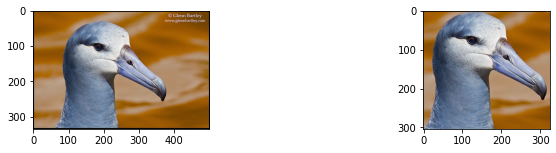

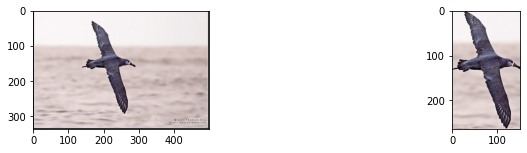

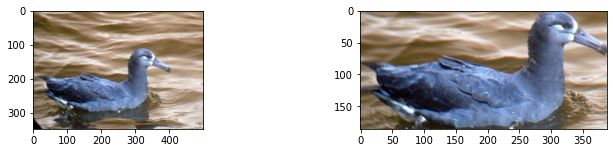

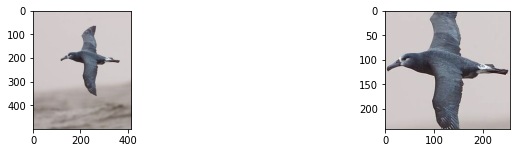

In [9]:
cnt = 1
for i in range(4):
    num = i
    test_path = 'dataset/raw/'+images_info[num]
    test_image = cv2.imread(test_path)
    
    # 기본 이미지 출력
    plt.figure(figsize=[12,10])
    plt.subplot(4,2,cnt)
    plt.imshow(test_image)
    cnt += 1
    
    # crop 된 이미지 출력
    cropped_image = image_crop(test_image,bbox_pos[num])
    plt.subplot(4,2,cnt)
    plt.imshow(cropped_image)
    cnt += 1

## 2. 데이터 구성

### 전체 데이터 crop 수행

In [14]:
# X_data = []
# Y_data = []
# for idx,i in enumerate(tqdm(images_info)):
#     # Y_data
#     label_num = int(i.split('.')[0])-1
#     Y_data.append(label_num)
    
#     # X_data
#     path = os.path.join(raw_path,i)
#     image = cv2.imread(path)
#     cropped_image = image_crop(image,bbox_pos[idx])
#     return_image = cv2.resize(cropped_image,dsize=(224,224))
#     return_image = return_image / 255.0
#     X_data.append(return_image)
    
# X_data = np.array(X_data)
# Y_data = np.array(Y_data)

In [15]:
# if not os.path.isdir(train_path):
#     os.makedirs(train_path)

In [16]:
# np.save(train_path+'X_data.npy',X_data)
# np.save(train_path+'Y_data.npy',Y_data)

In [10]:
X_data = np.load(train_path+'X_data.npy')
Y_data = np.load(train_path+'Y_data.npy')

In [11]:
print(X_data.shape)
print(Y_data.shape)

(11788, 224, 224, 3)
(11788,)


##### 데이터분포확인

(0.0, 60.0)

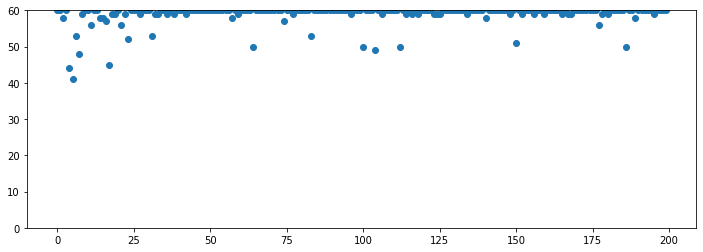

In [12]:
data_cnt = dict(Counter(Y_data))
plt.figure(figsize=[12,4])
plt.scatter(data_cnt.keys(),data_cnt.values())
plt.ylim([0,60])

##### 클래스별 균일 분할

In [13]:
# label 별 개수
data_cnt = dict(Counter(Y_data))

# split 비율 지정
train_range = 0.7
valid_range = 0.2


train_X = []
valid_X = []
test_X = []
train_Y = []
valid_Y = []
test_Y = []

cnt = 0
for idx in tqdm(data_cnt.keys()):

    label_total_len = data_cnt[idx]
    train_len = int(np.round(label_total_len * train_range))
    valid_len = int(np.round(label_total_len * valid_range))
    test_len = label_total_len - train_len - valid_len
    
    len_1 = cnt + train_len
    len_2 = len_1 + valid_len
    len_3 = len_2 + test_len
        
    train_X.extend(X_data[cnt:len_1])
    valid_X.extend(X_data[len_1:len_2])
    test_X.extend(X_data[len_2:len_3])
    train_Y.extend(Y_data[cnt:len_1])
    valid_Y.extend(Y_data[len_1:len_2])
    test_Y.extend(Y_data[len_2:len_3])
    
    cnt += label_total_len

100%|██████████| 200/200 [00:00<00:00, 16909.11it/s]


In [14]:
train_X = np.array(train_X)
valid_X = np.array(valid_X)
test_X = np.array(test_X)
train_Y = np.array(train_Y)
valid_Y = np.array(valid_Y)
test_Y = np.array(test_Y)

print(train_X.shape)
print(valid_X.shape)
print(test_X.shape)
print(train_Y.shape)
print(valid_Y.shape)
print(test_Y.shape)

(8244, 224, 224, 3)
(2366, 224, 224, 3)
(1178, 224, 224, 3)
(8244,)
(2366,)
(1178,)


##### 데이터 확인

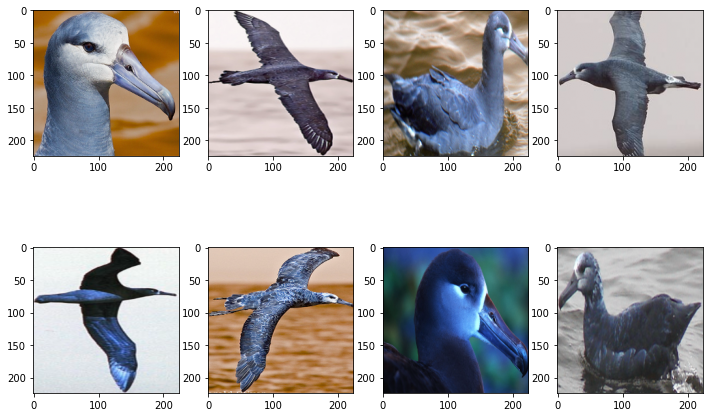

In [15]:
fig = plt.figure(figsize=[12,8])
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(train_X[i])

## 3. 모델 정의

In [16]:
# tf.keras에서 사전 학습된 모델 불러오기
from tensorflow.keras.applications import MobileNetV2,vgg19
mobilev2 = MobileNetV2()
vgg_model = vgg19.VGG19()

In [17]:
def initialize_weights(model):
    '''가중치 초기화'''
    for layer in model.layers[:-1]:
        layer.trainable = True
    for layer in model.layers[:-1]: 
        if 'kernel' in layer.__dict__:
            kernel_shape = np.array(layer.get_weights()).shape
            layer.set_weights(tf.random.normal(kernel_shape, 0, 1))     
    return model

def train_all_weights(model):
    '''모든 weights 학습'''
    x = model.layers[-2].output
    outputs = tf.keras.layers.Dense(200, activation='softmax')(x)
    return_model = tf.keras.Model(inputs=model.input, outputs=outputs)
    return_model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return return_model

def train_some_weights(model,range_num):
    '''일부 weights만 학습'''
    x = model.layers[-2].output
    x = tf.keras.layers.Dense(200, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(200, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(200, activation='softmax')(x)
    return_model = tf.keras.Model(inputs=model.input, outputs=outputs)
    
    for layer in return_model.layers[:range_num]:
        layer.trainable = False
    for layer in return_model.layers[range_num:]:
        layer.trainable = True
    return_model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return return_model

## 4. 학습

##### Test1
- mobileNet2 사용 / 가중치 전체 학습

In [26]:
test_num = 1

In [27]:
USE_model = mobilev2
USE_model = initialize_weights(USE_model)
USE_model = train_all_weights(USE_model)

In [28]:
checkpoint_path,log_dir = make_path(test_num)
earlystop_callback,cp_callback,tensorboard_callback = make_callback(checkpoint_path,log_dir)

checkpoints/Image_Classification/TEST1 -- Folder already exists 

logs/fit/TEST1 -- Folder already exists 



In [29]:
# history_1 = USE_model.fit(train_X, train_Y, 
#                               epochs=100, 
#                               validation_data = (valid_X,valid_Y),
#                               batch_size=32,
#                               callbacks=[earlystop_callback, cp_callback, tensorboard_callback])

#### Test2
- mobileNet2 사용 / 가중치 일부학습 (추가한 레이어만 학습하였음)

In [54]:
test_num = 2

In [55]:
USE_model = mobilev2
USE_model = train_some_weights(USE_model,-5)

In [56]:
checkpoint_path,log_dir = make_path(test_num)
earlystop_callback,cp_callback,tensorboard_callback = make_callback(checkpoint_path,log_dir)

checkpoints/Image_Classification/TEST2 -- Folder create complete 

logs/fit/TEST2 -- Folder create complete 



In [18]:
# history_2 = USE_model.fit(train_X, train_Y, 
#                               epochs=60, 
#                               validation_data = (valid_X,valid_Y),
#                               batch_size=32,
#                               callbacks=[earlystop_callback, cp_callback, tensorboard_callback])

##### Test3
- mobileNet2 사용 / 가중치 일부학습 (range_num : -10)

In [19]:
test_num = 3

In [20]:
USE_model = mobilev2
USE_model = train_some_weights(USE_model,-10)

In [21]:
checkpoint_path,log_dir = make_path(test_num)
earlystop_callback,cp_callback,tensorboard_callback = make_callback(checkpoint_path,log_dir)

checkpoints/Image_Classification/TEST3 -- Folder already exists 

logs/fit/TEST3 -- Folder already exists 



In [22]:
history_3 = USE_model.fit(train_X, train_Y, 
                              epochs=60, 
                              validation_data = (valid_X,valid_Y),
                              batch_size=32,
                              callbacks=[earlystop_callback, cp_callback, tensorboard_callback])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/60
258/258 [==============================] - 18s 51ms/step - loss: 5.2617 - accuracy: 0.0096 - val_loss: 5.1168 - val_accuracy: 0.0254

Epoch 00001: val_loss improved from inf to 5.11678, saving model to checkpoints/Image_Classification/TEST3/TEST3
Epoch 2/60
258/258 [==============================] - 10s 40ms/step - loss: 4.9754 - accuracy: 0.0411 - val_loss: 4.7137 - val_accuracy: 0.0748

Epoch 00002: val_loss improved from 5.11678 to 4.71366, saving model to checkpoints/Image_Classification/TEST3/TEST3
Epoch 3/60
258/258 [==============================] - 10s 40ms/step - loss: 4.5260 - accuracy: 0.0796 - val_loss: 4.0719 - val_accuracy: 0.1585

Epoch 00003: val_loss improved from 4.71366 to 4.07189, saving model to checkpoints/Image_Classification/TEST3/TEST3
Epoch 4/60
258/258 [==============================] - 10s 40ms/step - loss: 3.9499 - accuracy: 0.1366 - val_loss: 3.4524 - val_accuracy: 0.2308

Epoch 00004: val_loss improved from 4.07189 to 3.45235, saving model to c


Epoch 00033: val_loss improved from 1.59546 to 1.59284, saving model to checkpoints/Image_Classification/TEST3/TEST3
Epoch 34/60
258/258 [==============================] - 10s 40ms/step - loss: 0.4648 - accuracy: 0.8794 - val_loss: 1.5996 - val_accuracy: 0.5757

Epoch 00034: val_loss did not improve from 1.59284
Epoch 35/60
258/258 [==============================] - 10s 40ms/step - loss: 0.4402 - accuracy: 0.8866 - val_loss: 1.6038 - val_accuracy: 0.5697

Epoch 00035: val_loss did not improve from 1.59284
Epoch 36/60
258/258 [==============================] - 10s 40ms/step - loss: 0.4136 - accuracy: 0.8946 - val_loss: 1.6194 - val_accuracy: 0.5735

Epoch 00036: val_loss did not improve from 1.59284
Epoch 37/60
258/258 [==============================] - 10s 40ms/step - loss: 0.3955 - accuracy: 0.8980 - val_loss: 1.6308 - val_accuracy: 0.5735

Epoch 00037: val_loss did not improve from 1.59284
Epoch 38/60
258/258 [==============================] - 10s 40ms/step - loss: 0.3730 - accuracy

In [23]:
USE_model.evaluate(test_X,test_Y)

37/37 [==============================] - 1s 33ms/step - loss: 1.7341 - accuracy: 0.5823


[1.7341481447219849, 0.5823429822921753]

##### Test4
- mobileNet2 사용 / 가중치 일부학습 (range_num : -15)

In [24]:
test_num = 4

In [25]:
USE_model = mobilev2
USE_model = train_some_weights(USE_model,-15)

In [26]:
checkpoint_path,log_dir = make_path(test_num)
earlystop_callback,cp_callback,tensorboard_callback = make_callback(checkpoint_path,log_dir)

checkpoints/Image_Classification/TEST4 -- Folder already exists 

logs/fit/TEST4 -- Folder already exists 



In [28]:
history_4 = USE_model.fit(train_X, train_Y, 
                              epochs=60, 
                              validation_data = (valid_X,valid_Y),
                              batch_size=32,
                              callbacks=[earlystop_callback, cp_callback, tensorboard_callback])

Epoch 1/60
258/258 [==============================] - 14s 49ms/step - loss: 5.2337 - accuracy: 0.0178 - val_loss: 5.0434 - val_accuracy: 0.0355

Epoch 00001: val_loss improved from inf to 5.04338, saving model to checkpoints/Image_Classification/TEST4/TEST4
Epoch 2/60
258/258 [==============================] - 10s 39ms/step - loss: 4.8396 - accuracy: 0.0598 - val_loss: 4.4252 - val_accuracy: 0.1171

Epoch 00002: val_loss improved from 5.04338 to 4.42518, saving model to checkpoints/Image_Classification/TEST4/TEST4
Epoch 3/60
258/258 [==============================] - 10s 39ms/step - loss: 4.2016 - accuracy: 0.1196 - val_loss: 3.5998 - val_accuracy: 0.2215

Epoch 00003: val_loss improved from 4.42518 to 3.59984, saving model to checkpoints/Image_Classification/TEST4/TEST4
Epoch 4/60
258/258 [==============================] - 10s 39ms/step - loss: 3.5328 - accuracy: 0.2021 - val_loss: 2.9767 - val_accuracy: 0.3123

Epoch 00004: val_loss improved from 3.59984 to 2.97674, saving model to c

In [29]:
USE_model.evaluate(test_X,test_Y)

37/37 [==============================] - 1s 28ms/step - loss: 1.7370 - accuracy: 0.5985


[1.737044334411621, 0.598471999168396]

##### Test5
- mobileNet2 사용 / 가중치 일부학습 (range_num : -20)

In [30]:
test_num = 5

In [31]:
USE_model = mobilev2
USE_model = train_some_weights(USE_model,-20)

In [32]:
checkpoint_path,log_dir = make_path(test_num)
earlystop_callback,cp_callback,tensorboard_callback = make_callback(checkpoint_path,log_dir)

checkpoints/Image_Classification/TEST5 -- Folder create complete 

logs/fit/TEST5 -- Folder create complete 



In [33]:
history_5 = USE_model.fit(train_X, train_Y, 
                              epochs=60, 
                              validation_data = (valid_X,valid_Y),
                              batch_size=32,
                              callbacks=[earlystop_callback, cp_callback, tensorboard_callback])

Epoch 1/60
258/258 [==============================] - 15s 50ms/step - loss: 5.2210 - accuracy: 0.0175 - val_loss: 4.9794 - val_accuracy: 0.0456

Epoch 00001: val_loss improved from inf to 4.97941, saving model to checkpoints/Image_Classification/TEST5/TEST5
Epoch 2/60
258/258 [==============================] - 10s 40ms/step - loss: 4.7309 - accuracy: 0.0716 - val_loss: 4.1875 - val_accuracy: 0.1407

Epoch 00002: val_loss improved from 4.97941 to 4.18749, saving model to checkpoints/Image_Classification/TEST5/TEST5
Epoch 3/60
258/258 [==============================] - 10s 40ms/step - loss: 3.9168 - accuracy: 0.1705 - val_loss: 3.2621 - val_accuracy: 0.2773

Epoch 00003: val_loss improved from 4.18749 to 3.26209, saving model to checkpoints/Image_Classification/TEST5/TEST5
Epoch 4/60
258/258 [==============================] - 10s 40ms/step - loss: 3.0899 - accuracy: 0.2841 - val_loss: 2.6842 - val_accuracy: 0.3559

Epoch 00004: val_loss improved from 3.26209 to 2.68417, saving model to c

In [34]:
USE_model.evaluate(test_X,test_Y)

37/37 [==============================] - 1s 28ms/step - loss: 1.8231 - accuracy: 0.6205


[1.8230693340301514, 0.6205433011054993]

##### Test6
- mobileNet2 사용 / 가중치 일부학습 (range_num : -25)

In [35]:
test_num = 6

In [36]:
USE_model = mobilev2
USE_model = train_some_weights(USE_model,-25)

In [37]:
checkpoint_path,log_dir = make_path(test_num)
earlystop_callback,cp_callback,tensorboard_callback = make_callback(checkpoint_path,log_dir)

checkpoints/Image_Classification/TEST6 -- Folder create complete 

logs/fit/TEST6 -- Folder create complete 



In [38]:
history_6 = USE_model.fit(train_X, train_Y, 
                              epochs=60, 
                              validation_data = (valid_X,valid_Y),
                              batch_size=32,
                              callbacks=[earlystop_callback, cp_callback, tensorboard_callback])

Epoch 1/60
258/258 [==============================] - 17s 51ms/step - loss: 5.1931 - accuracy: 0.0189 - val_loss: 4.9038 - val_accuracy: 0.0672

Epoch 00001: val_loss improved from inf to 4.90385, saving model to checkpoints/Image_Classification/TEST6/TEST6
Epoch 2/60
258/258 [==============================] - 10s 40ms/step - loss: 4.4960 - accuracy: 0.1146 - val_loss: 3.8311 - val_accuracy: 0.2363

Epoch 00002: val_loss improved from 4.90385 to 3.83113, saving model to checkpoints/Image_Classification/TEST6/TEST6
Epoch 3/60
258/258 [==============================] - 11s 41ms/step - loss: 3.3502 - accuracy: 0.2678 - val_loss: 2.7453 - val_accuracy: 0.3910

Epoch 00003: val_loss improved from 3.83113 to 2.74528, saving model to checkpoints/Image_Classification/TEST6/TEST6
Epoch 4/60
258/258 [==============================] - 10s 41ms/step - loss: 2.3770 - accuracy: 0.4260 - val_loss: 2.1129 - val_accuracy: 0.5068

Epoch 00004: val_loss improved from 2.74528 to 2.11288, saving model to c

Epoch 39/60
258/258 [==============================] - 11s 41ms/step - loss: 0.0448 - accuracy: 0.9922 - val_loss: 1.7080 - val_accuracy: 0.6086

Epoch 00039: val_loss did not improve from 1.48068
Epoch 40/60
258/258 [==============================] - 11s 41ms/step - loss: 0.0462 - accuracy: 0.9919 - val_loss: 1.7229 - val_accuracy: 0.6205

Epoch 00040: val_loss did not improve from 1.48068
Epoch 41/60
258/258 [==============================] - 11s 41ms/step - loss: 0.0434 - accuracy: 0.9918 - val_loss: 1.7186 - val_accuracy: 0.6247

Epoch 00041: val_loss did not improve from 1.48068
Epoch 42/60
258/258 [==============================] - 11s 41ms/step - loss: 0.0442 - accuracy: 0.9902 - val_loss: 1.7672 - val_accuracy: 0.6141

Epoch 00042: val_loss did not improve from 1.48068
Epoch 43/60
258/258 [==============================] - 11s 41ms/step - loss: 0.0413 - accuracy: 0.9925 - val_loss: 1.7778 - val_accuracy: 0.6145

Epoch 00043: val_loss did not improve from 1.48068
Epoch 44/60
258

In [39]:
USE_model.evaluate(test_X,test_Y)

37/37 [==============================] - 1s 30ms/step - loss: 1.8484 - accuracy: 0.6239


[1.8484141826629639, 0.6239388585090637]

##### Test7
- mobileNet2 사용 / 가중치 일부학습 (range_num : -25)

In [40]:
test_num = 7

In [41]:
USE_model = mobilev2
USE_model = train_some_weights(USE_model,-30)

In [42]:
checkpoint_path,log_dir = make_path(test_num)
earlystop_callback,cp_callback,tensorboard_callback = make_callback(checkpoint_path,log_dir)

checkpoints/Image_Classification/TEST7 -- Folder create complete 

logs/fit/TEST7 -- Folder create complete 



In [43]:
history_7 = USE_model.fit(train_X, train_Y, 
                              epochs=60, 
                              validation_data = (valid_X,valid_Y),
                              batch_size=32,
                              callbacks=[earlystop_callback, cp_callback, tensorboard_callback])

Epoch 1/60
258/258 [==============================] - 15s 51ms/step - loss: 5.0726 - accuracy: 0.0334 - val_loss: 4.6629 - val_accuracy: 0.1331

Epoch 00001: val_loss improved from inf to 4.66292, saving model to checkpoints/Image_Classification/TEST7/TEST7
Epoch 2/60
258/258 [==============================] - 11s 41ms/step - loss: 4.0012 - accuracy: 0.1989 - val_loss: 3.2468 - val_accuracy: 0.3631

Epoch 00002: val_loss improved from 4.66292 to 3.24678, saving model to checkpoints/Image_Classification/TEST7/TEST7
Epoch 3/60
258/258 [==============================] - 11s 42ms/step - loss: 2.5326 - accuracy: 0.4370 - val_loss: 2.2265 - val_accuracy: 0.4877

Epoch 00003: val_loss improved from 3.24678 to 2.22647, saving model to checkpoints/Image_Classification/TEST7/TEST7
Epoch 4/60
258/258 [==============================] - 11s 42ms/step - loss: 1.5445 - accuracy: 0.6271 - val_loss: 1.8532 - val_accuracy: 0.5473

Epoch 00004: val_loss improved from 2.22647 to 1.85317, saving model to c

Epoch 40/60
258/258 [==============================] - 11s 42ms/step - loss: 0.0249 - accuracy: 0.9961 - val_loss: 1.7419 - val_accuracy: 0.6302

Epoch 00040: val_loss did not improve from 1.54329
Epoch 41/60
258/258 [==============================] - 11s 42ms/step - loss: 0.0237 - accuracy: 0.9962 - val_loss: 1.7563 - val_accuracy: 0.6285

Epoch 00041: val_loss did not improve from 1.54329
Epoch 42/60
258/258 [==============================] - 11s 42ms/step - loss: 0.0215 - accuracy: 0.9970 - val_loss: 1.7679 - val_accuracy: 0.6243

Epoch 00042: val_loss did not improve from 1.54329
Epoch 43/60
258/258 [==============================] - 11s 42ms/step - loss: 0.0223 - accuracy: 0.9961 - val_loss: 1.7275 - val_accuracy: 0.6293

Epoch 00043: val_loss did not improve from 1.54329
Epoch 44/60
258/258 [==============================] - 11s 42ms/step - loss: 0.0206 - accuracy: 0.9967 - val_loss: 1.7122 - val_accuracy: 0.6289

Epoch 00044: val_loss did not improve from 1.54329
Epoch 45/60
258

In [44]:
USE_model.evaluate(test_X,test_Y)

37/37 [==============================] - 1s 29ms/step - loss: 1.9103 - accuracy: 0.6036


[1.9102580547332764, 0.6035653352737427]

##### Test8
- mobileNet2 사용 / 가중치 일부학습 (range_num : -30) / 에폭 최대

In [45]:
test_num = 8

In [46]:
USE_model = mobilev2
USE_model = train_some_weights(USE_model,-30)

In [47]:
checkpoint_path,log_dir = make_path(test_num)
earlystop_callback,cp_callback,tensorboard_callback = make_callback(checkpoint_path,log_dir)

checkpoints/Image_Classification/TEST8 -- Folder create complete 

logs/fit/TEST8 -- Folder create complete 



In [48]:
history_8 = USE_model.fit(train_X, train_Y, 
                              epochs=1000, 
                              validation_data = (valid_X,valid_Y),
                              batch_size=32,
                              callbacks=[earlystop_callback, cp_callback, tensorboard_callback])

Epoch 1/1000
258/258 [==============================] - 16s 51ms/step - loss: 4.9013 - accuracy: 0.0660 - val_loss: 4.3421 - val_accuracy: 0.2041

Epoch 00001: val_loss improved from inf to 4.34209, saving model to checkpoints/Image_Classification/TEST8/TEST8
Epoch 2/1000
258/258 [==============================] - 11s 41ms/step - loss: 3.2898 - accuracy: 0.3433 - val_loss: 2.6366 - val_accuracy: 0.4594

Epoch 00002: val_loss improved from 4.34209 to 2.63662, saving model to checkpoints/Image_Classification/TEST8/TEST8
Epoch 3/1000
258/258 [==============================] - 11s 41ms/step - loss: 1.6760 - accuracy: 0.6282 - val_loss: 1.9006 - val_accuracy: 0.5486

Epoch 00003: val_loss improved from 2.63662 to 1.90061, saving model to checkpoints/Image_Classification/TEST8/TEST8
Epoch 4/1000
258/258 [==============================] - 11s 42ms/step - loss: 0.8922 - accuracy: 0.8073 - val_loss: 1.7356 - val_accuracy: 0.5790

Epoch 00004: val_loss improved from 1.90061 to 1.73562, saving mo


Epoch 00039: val_loss did not improve from 1.53258
Epoch 40/1000
258/258 [==============================] - 11s 41ms/step - loss: 0.0155 - accuracy: 0.9979 - val_loss: 1.6734 - val_accuracy: 0.6285

Epoch 00040: val_loss did not improve from 1.53258
Epoch 41/1000
258/258 [==============================] - 11s 42ms/step - loss: 0.0176 - accuracy: 0.9976 - val_loss: 1.7194 - val_accuracy: 0.6260

Epoch 00041: val_loss did not improve from 1.53258
Epoch 42/1000
258/258 [==============================] - 11s 41ms/step - loss: 0.0161 - accuracy: 0.9984 - val_loss: 1.7186 - val_accuracy: 0.6255

Epoch 00042: val_loss did not improve from 1.53258
Epoch 43/1000
258/258 [==============================] - 11s 42ms/step - loss: 0.0162 - accuracy: 0.9971 - val_loss: 1.7318 - val_accuracy: 0.6175

Epoch 00043: val_loss did not improve from 1.53258
Epoch 44/1000
258/258 [==============================] - 11s 41ms/step - loss: 0.0156 - accuracy: 0.9981 - val_loss: 1.7533 - val_accuracy: 0.6175

Epoc

Epoch 81/1000
258/258 [==============================] - 11s 41ms/step - loss: 0.0064 - accuracy: 0.9992 - val_loss: 1.8321 - val_accuracy: 0.6255

Epoch 00081: val_loss did not improve from 1.53258
Epoch 82/1000
258/258 [==============================] - 11s 42ms/step - loss: 0.0072 - accuracy: 0.9994 - val_loss: 1.8251 - val_accuracy: 0.6310

Epoch 00082: val_loss did not improve from 1.53258
Epoch 83/1000
258/258 [==============================] - 11s 42ms/step - loss: 0.0073 - accuracy: 0.9989 - val_loss: 1.8132 - val_accuracy: 0.6293

Epoch 00083: val_loss did not improve from 1.53258
Epoch 84/1000
258/258 [==============================] - 11s 41ms/step - loss: 0.0062 - accuracy: 0.9992 - val_loss: 1.8263 - val_accuracy: 0.6260

Epoch 00084: val_loss did not improve from 1.53258
Epoch 85/1000
258/258 [==============================] - 11s 41ms/step - loss: 0.0061 - accuracy: 0.9994 - val_loss: 1.8350 - val_accuracy: 0.6293

Epoch 00085: val_loss did not improve from 1.53258
Epoch

In [49]:
USE_model.evaluate(test_X,test_Y)

37/37 [==============================] - 1s 29ms/step - loss: 2.0707 - accuracy: 0.6053


[2.0707037448883057, 0.6052631735801697]

## 미사용 

##### 데이터 분할 (기존)

In [17]:
# # seed 설정
# random_state = 5 
# np.random.seed(random_state)

# # 데이터 셔플위한 인덱스
# random_idx = np.arange(0,X_data.shape[0],1) 
# np.random.shuffle(random_idx)

# # split 비율 지정
# train_range = int(len(X_data)*0.9)

# # X 데이터 
# train_X = np.array([X_data[i] for i in random_idx[:train_range]])
# test_X = np.array([X_data[i] for i in random_idx[train_range:]])

# # Y 데이터
# train_Y = np.array([Y_data[i] for i in random_idx[:train_range]])
# test_Y = np.array([Y_data[i] for i in random_idx[train_range:]])

# print(train_X.shape)
# print(test_X.shape)
# print(train_Y.shape)
# print(test_Y.shape)